In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import matplotlib.dates as mdates
import seaborn as sns
# from sklearn.cluster import KMeans

In [2]:
user = "aabounak"
password = "mysecretpassword"
host = "localhost"
port = "5432"
database = "piscineds"

def connect_to_postgres():
  return create_engine(
    url=f"postgresql://{user}:{password}@{host}:{port}/{database}"
  )

In [3]:
engine = connect_to_postgres()

In [4]:
with engine.connect() as connection:
  result = connection.execute(text('select * from customers limit 12000000'))
  data = result.fetchall()

columns_names = result.keys()
df = pd.DataFrame(data, columns=columns_names)
df.head()

,event_time,event_type,product_id,price,user_id,user_session,category_id,category_code,brand
0,2022-12-01 00:00:00+00:00,remove_from_cart,5712790,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,1.487580e+18,None,None
1,2022-12-01 00:00:02+00:00,cart,4958,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,1.487580e+18,None,None
2,2022-12-01 00:00:05+00:00,view,5848413,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,1.487580e+18,None,None
3,2022-12-01 00:00:07+00:00,view,5824148,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,NaN,None,None
4,2022-12-01 00:00:09+00:00,view,5773361,2.62,560109803,38cf4ba1-4a0a-4c9e-b870-46685d105f95,1.487580e+18,None,None


In [5]:

df.to_csv(r'./\selected_data.csv')

In [6]:
sns.set_style("darkgrid")

### Exercise 00

<Axes: ylabel='count'>

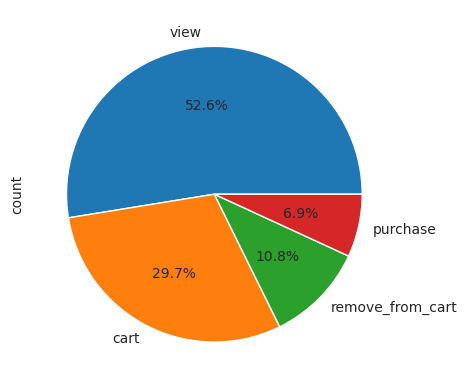

In [7]:
df['event_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')

### Exercise 01

In [8]:
df['event_time'] = pd.to_datetime(df['event_time'])
filtered_data = df[(df['event_type'] == 'purchase')]

In [9]:
filtered_data['year'] = filtered_data['event_time'].dt.year
filtered_data['month'] = filtered_data['event_time'].dt.month
filtered_data['day'] = filtered_data['event_time'].dt.day

/tmp/ipykernel_424/1658810200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['event_time'].dt.year
/tmp/ipykernel_424/1658810200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['event_time'].dt.month
/tmp/ipykernel_424/1658810200.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

<Axes: xlabel='Date', ylabel='Number of customers'>

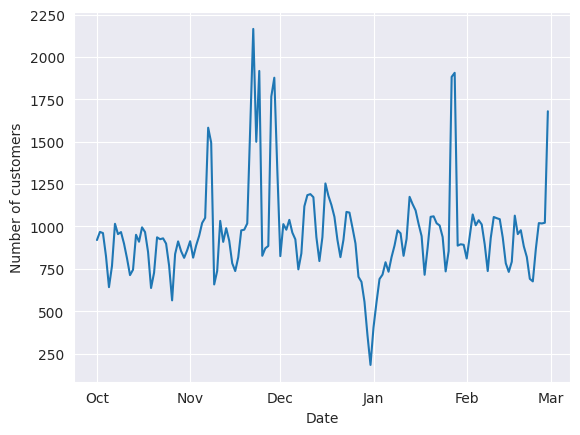

In [10]:
daily_customer_counts = filtered_data.groupby(['year', 'month', 'day'])['user_id'].nunique().reset_index()
daily_customer_counts['date'] = pd.to_datetime(daily_customer_counts[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

plt.ylabel('Number of customers')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

sns.lineplot(data=daily_customer_counts, x='date', y='user_id')

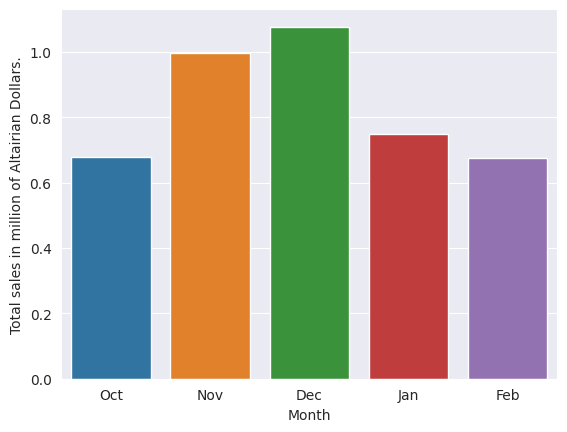

In [11]:
total_sales = filtered_data.groupby(['year', 'month'])['price'].sum().reset_index()
total_sales['date'] = pd.to_datetime(total_sales[['year', 'month']].astype(str).agg('-'.join, axis=1)).dt.strftime('%b')

total_sales['price_in_million'] = total_sales['price'] / 1000000

sns.barplot(data=total_sales, x='date', y='price_in_million')

plt.xlabel('Month')
plt.ylabel('Total sales in million of Altairian Dollars.')
plt.show()

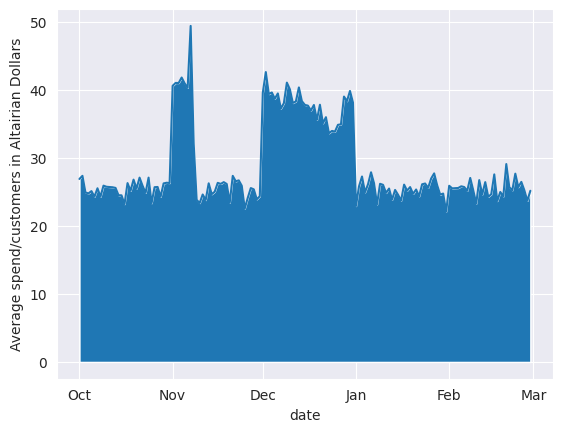

In [12]:
total_sales = filtered_data.groupby(['year', 'month', 'day'])['price'].sum().reset_index()
merged_data = pd.merge(total_sales, daily_customer_counts, on=['year', 'month', 'day'])
merged_data['average_spend_per_customer'] = merged_data['price'] / merged_data['user_id']
merged_data['date'] = pd.to_datetime(merged_data[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))

sns.lineplot(data=merged_data, x='date', y='average_spend_per_customer')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.fill_between(merged_data['date'], merged_data['average_spend_per_customer'])
plt.ylabel('Average spend/customers in Altairian Dollars')
plt.show()


### Ex02

count    824364.000000
mean          5.063609
std           9.830846
min         -79.370000
25%           1.510000
50%           3.000000
75%           5.400000
max         327.780000
Name: price, dtype: float64


<Axes: xlabel='price'>

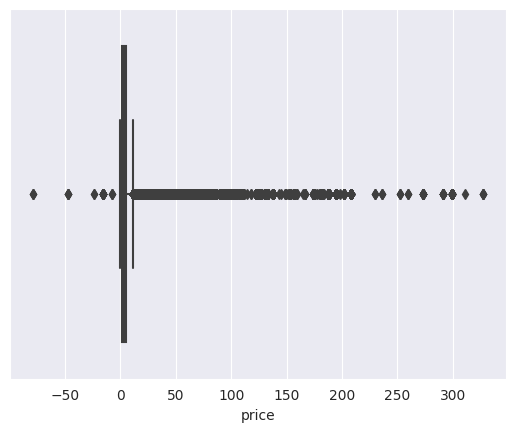

In [13]:
copy_df = filtered_data.copy()
copy_df['price'] = copy_df['price'].astype(float)

print(copy_df['price'].describe())
sns.boxplot(data=copy_df, x='price')

<Axes: xlabel='price'>

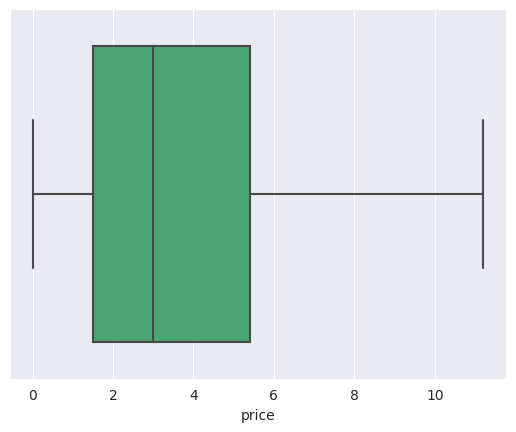

In [14]:
sns.boxplot(data=copy_df, x='price', showfliers=False, color='mediumseagreen')

In [15]:
copy_df.head(10)

,event_time,event_type,product_id,price,user_id,user_session,category_id,category_code,brand,year,month,day
21,2022-12-01 00:17:50+00:00,purchase,4554,0.38,473613801,d1e90c6a-c030-4d06-aaaf-6d12ec502bb9,1.487580e+18,None,None,2022,12,1
89,2022-12-01 00:43:51+00:00,purchase,5754991,6.19,579950721,f39acf4b-11d5-479d-84a7-04f5bc6255ce,NaN,None,None,2022,12,1
90,2022-12-01 00:43:51+00:00,purchase,5815137,3.97,579950721,f39acf4b-11d5-479d-84a7-04f5bc6255ce,NaN,None,None,2022,12,1
91,2022-12-01 00:43:51+00:00,purchase,8381,15.08,579950721,f39acf4b-11d5-479d-84a7-04f5bc6255ce,1.487580e+18,None,None,2022,12,1
192,2022-12-01 01:15:01+00:00,purchase,36406,3.17,436271415,7fe6b59f-7a31-4e1f-9324-6720360306a4,1.487580e+18,None,None,2022,12,1
193,2022-12-01 01:15:01+00:00,purchase,5803082,3.49,436271415,7fe6b59f-7a31-4e1f-9324-6720360306a4,1.487580e+18,None,None,2022,12,1
194,2022-12-01 01:18:32+00:00,purchase,5899359,4.44,356011474,e38133d8-bd17-e4e1-194f-e01d325312db,NaN,None,None,2022,12,1
195,2022-12-01 01:18:32+00:00,purchase,5907837,1.43,356011474,e38133d8-bd17-e4e1-194f-e01d325312db,1.487580e+18,None,None,2022,12,1
196,2022-12-01 01:18:32+00:00,purchase,5907852,1.43,356011474,e38133d8-bd17-e4e1-194f-e01d325312db,1.487580e+18,None,None,2022,12,1
197,2022-12-01 01:18:32+00:00,purchase,5907871,1.43,356011474,e38133d8-bd17-e4e1-194f-e01d325312db,1.487580e+18,None,None,2022,12,1


In [26]:
cart_df = df[(df['event_type'] == 'cart')]
copy_cart = cart_df.copy()

In [27]:
avg_basket = copy_cart.groupby('user_id')['price'].mean().reset_index(name='avg_basket_price')

avg_basket.head(10)

,user_id,avg_basket_price
0,2963072,6.555714
1,4661182,19.37
2,5493470,2.3
3,6217356,7.97
4,8194617,5.56
5,8846226,4.425
6,9794320,7.978095
7,10079204,12.905
8,10120387,0.0
9,10280338,2.971391


<Axes: xlabel='avg_basket_price'>

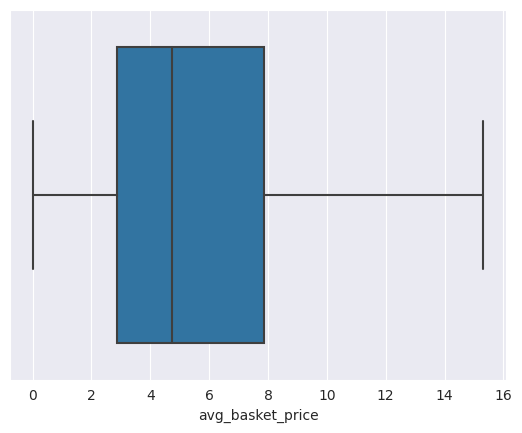

In [28]:
sns.boxplot(data=avg_basket, x='avg_basket_price', showfliers=False)

### Ex03